In [1]:
import string
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import numpy as np
import math

import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from langdetect import detect, DetectorFactory

import matplotlib.pyplot as plt

import sys
import json
import re

import pandas as pd
import codecs

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Natalie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Function to convert created date to a consistent format
def convert_created_date(date):
    if isinstance(date, float):  # UNIX timestamp
        return pd.to_datetime(date, unit='s').strftime('%Y-%m-%d %H:%M:%S')
    else:  # ISO format
        return pd.to_datetime(date).strftime('%Y-%m-%d %H:%M:%S')

In [3]:
DetectorFactory.seed = 0

def processText_lem(text, tokenizer, stemmer, stopwords, language = 'en'):
    """
    Perform tokenisation, normalisation (lower case and lemmatization) and stopword and twitter keyword removal.

    @param text: reddit submission or comment text
    @param tokenizer: tokeniser used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
    """
    # Detect language and only proceed if the text is in the target language
    try:
        detected_language = detect(text)
    except:
        return []  # Return empty list if language detection fails

    if detected_language != language:
        return []  # Return empty list if the text is not in the target language
        
    # covert all to lower case
    text = text.lower()
    # tokenise
    lTokens = tokenizer.tokenize(text)
    # strip whitespaces before and after
    lTokens = [token.strip() for token in lTokens]
    # stem (we use set to remove duplicates)
    lStemmedTokens = [stemmer.lemmatize(tok, pos = 'v') for tok in lTokens]
    
    regexHttp = re.compile("^http")
    regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")
    regexhash = re.compile(r"^(#|@)")
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    # Remove emojis from each token
    lStemmedTokens = [emoji_pattern.sub(r'', tok) for tok in lStemmedTokens]

    # remove stopwords, digits/urls
    return [tok for tok in lStemmedTokens if tok not in stopwords and 
            not tok.isdigit() and 
            tok and
            regexHttp.match(tok) == None and 
            regexDigit.match(tok) == None and
            regexhash.match(tok) == None]

In [4]:
# load json file
fJsonName_reddit = 'olympics_posts_reddit.json'
fJsonName_youtube = 'youtube_olympics_data_limited_250_per_hashtag.json'

# number of most frequent terms to display
freqNum = 50

# tweet tokeniser to use
tweetTokeniser = nltk.tokenize.TweetTokenizer()
# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)

# use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', " ","➡",'via','@','#', '...','..', '…', "sure",'"', "'", '`','.',"’",
                                                                '-',"it'","i'm","i've"]
# we use the lemmatisation approach
tweetStemmer_lem = WordNetLemmatizer()

## Reddit Engagement Rate Analysis

         Keyword  Total Engagement
0  Olympics 2024           1684136
1  Olympics 2020           2084023
2  Olympics 2016           1460435


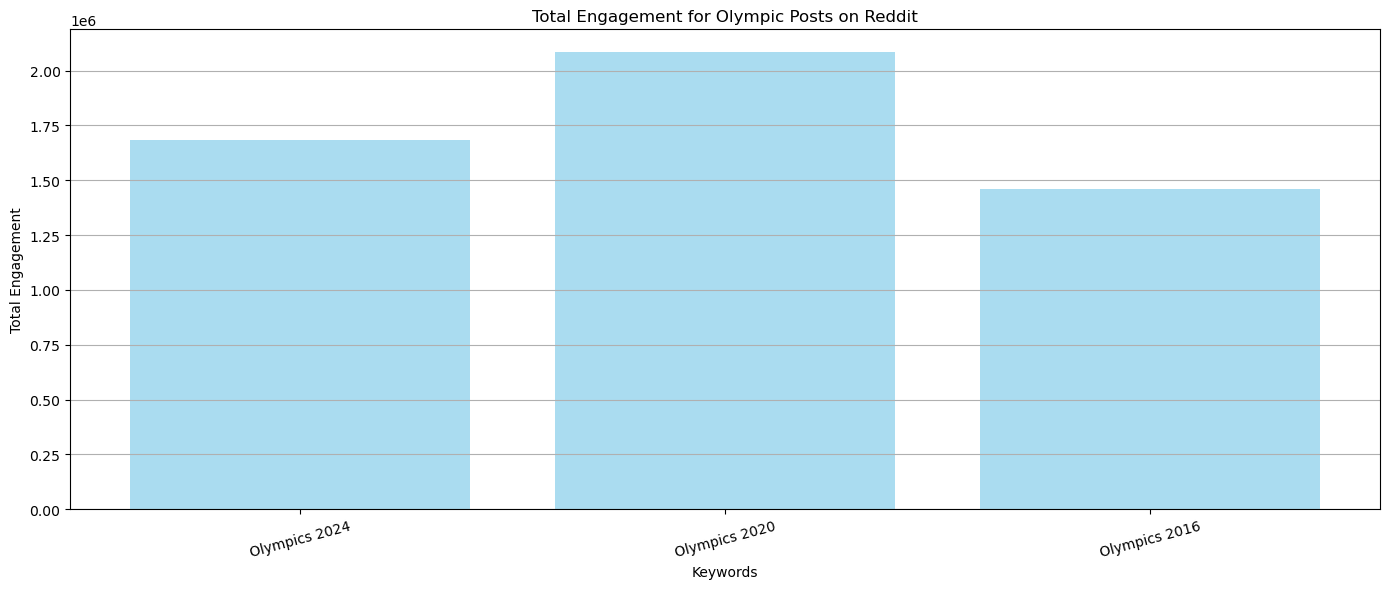

In [6]:
reddit_df = pd.read_json('olympics_posts_reddit.json')
reddit_df['comments_count'] = reddit_df['comments'].apply(lambda x: len(x))

# Define the keywords to filter
keywords = ['Olympics 2024', 'Olympics 2020', 'Olympics 2016']

# Initialize a dictionary to store results
results = {'Keyword': [], 'Total Engagement': [], 'Percentage Difference': []}

# Calculate total and average engagement for each keyword
for keyword in keywords:
    filtered_posts = reddit_df[reddit_df['keyword'] == keyword]
    total_engagement = (filtered_posts['score'].sum() + filtered_posts['comments_count'].sum())
    
    # Append results
    results['Keyword'].append(keyword)
    results['Total Engagement'].append(total_engagement)

# Create a results DataFrame
reddit_results_df = pd.DataFrame(results)

# Print the results
print(reddit_results_df)

# Visualize the results
# Create a figure 
fig, axs = plt.subplots(1, 1, figsize=(14, 6))

# Plot for Total Engagement 
axs.bar(reddit_results_df['Keyword'], reddit_results_df['Total Engagement'], color='skyblue', alpha=0.7)
axs.set_title('Total Engagement for Olympic Posts on Reddit')
axs.set_xlabel('Keywords')
axs.set_ylabel('Total Engagement')
axs.set_xticklabels(reddit_results_df['Keyword'], rotation=15)
axs.grid(axis='y')

# Adjust layout
plt.tight_layout()

# Show the plots 
plt.show()



## Youtube Engagement Rate Analysis

      Hashtag  Total Engagement
0  #paris2024          12623650
1  #tokyo2020          11492295
2    #rio2016           2263063


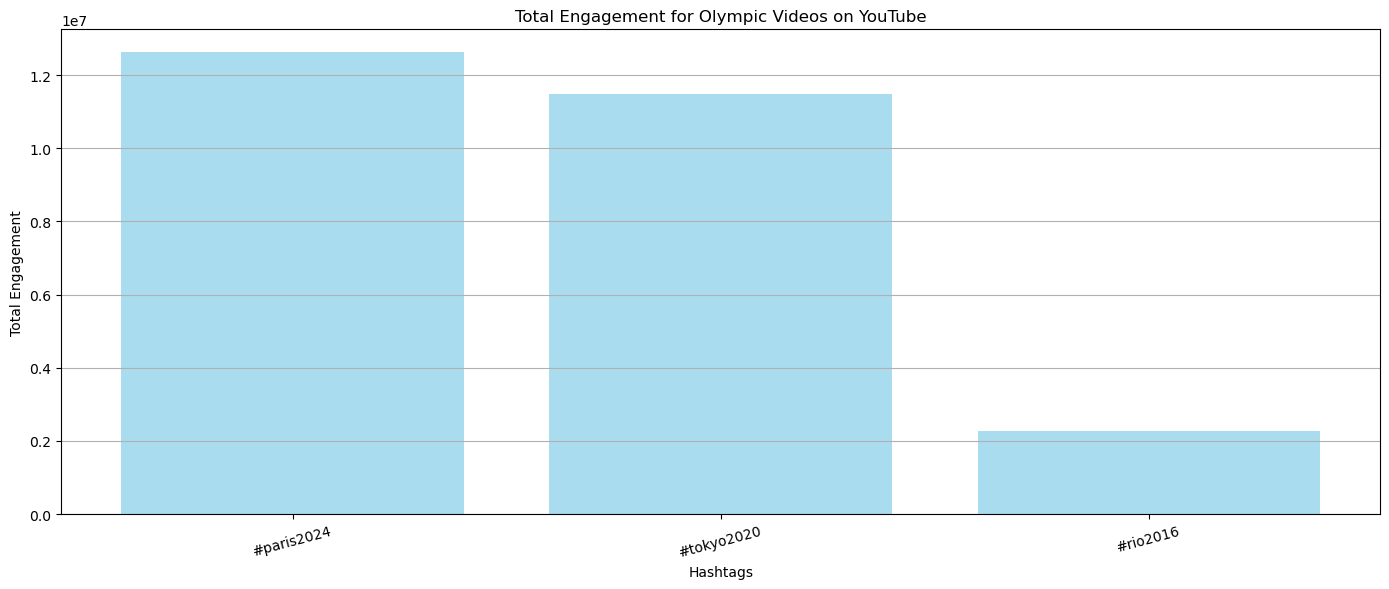

In [8]:
youtube_df = pd.read_json('youtube_olympics_data_limited_250_per_hashtag.json')

# Define the hashtags to filter
hashtags = ['#paris2024', '#tokyo2020', '#rio2016']

# Initialize a dictionary to store results
results = {'Hashtag': [], 'Total Engagement': []}

# Calculate total and average engagement for each keyword
for hashtag in hashtags:
    filtered_posts = youtube_df[youtube_df['Hashtag'] == hashtag]
    total_engagement = (filtered_posts['Like Count'].sum() + filtered_posts['Comment Count'].sum())

    # Append results
    results['Hashtag'].append(hashtag)
    results['Total Engagement'].append(total_engagement)

# Create a results DataFrame
youtube_results_df = pd.DataFrame(results)

# Print the results
print(youtube_results_df)

# Visualize the results
# Create a figure 
fig, axs = plt.subplots(1, 1, figsize=(14, 6))

# Plot for Total Engagement 
axs.bar(youtube_results_df['Hashtag'], youtube_results_df['Total Engagement'], color='skyblue', alpha=0.7)
axs.set_title('Total Engagement for Olympic Videos on YouTube')
axs.set_xlabel('Hashtags')
axs.set_ylabel('Total Engagement')
axs.set_xticklabels(youtube_results_df['Hashtag'], rotation=15)
axs.grid(axis='y')

# Adjust layout
plt.tight_layout()

# Show the plots side by side
plt.show()


In [60]:
# Print the results
reddit_results_df['increase_ratio'] = [(1684136-2084023)/2084023, (2084023-1460435)/1460435, 0]
print(reddit_results_df)

youtube_results_df['increase_ratio'] = [(12623650-11492295)/11492295, (11492295-2263063)/2263063, 0]
print(youtube_results_df)

         Keyword  Total Engagement  increase_ratio
0  Olympics 2024           1684136       -0.191882
1  Olympics 2020           2084023        0.426988
2  Olympics 2016           1460435        0.000000
      Hashtag  Total Engagement  increase_ratio
0  #paris2024          12623650        0.098445
1  #tokyo2020          11492295        4.078204
2    #rio2016           2263063        0.000000


### Engagement Analysis For Each Topic in Olympics 2024

In [10]:
import pandas as pd
# import json file 
with open(fJsonName_reddit, 'r') as f:
    dSubmissions = json.load(f)

olympics_post = []
for sub in dSubmissions:
    olympics_post.append({'title': sub['title'],
            'author': sub['author_id'],
            'text' : sub['selftext'],
            'created': sub['created'],
            'olympics':sub['keyword'],
            'score':sub['score'],
            'comments':sub['comments'],
            # 'comments_count':sub['comments'].apply(lambda x: len(x)),
            'type' : "post",
            })

olympics_comment_reddit = []
for sub in dSubmissions:
    for com in sub['comments']:
        olympics_comment_reddit.append({
            'title': sub['title'],
            'author':com['author_id'],
            'text':com['body'],
            'created':com['created'],
            'olympics':sub['keyword'],
            'score':com['score'],
            'type':"comment"
        })

reddit_df = pd.DataFrame(olympics_post)
reddit_df['comments_count'] = reddit_df['comments'].apply(lambda x:len(x))
reddit_com_df = pd.DataFrame(olympics_comment_reddit)

In [11]:
with open(fJsonName_youtube, 'r') as f:
    ySubmissions = json.load(f)

olympics_post2 = []
for sub in ySubmissions:
    olympics_post2.append({'title': sub['Video Title'],
            'text' : sub['Description'],
            'olympics':sub['Hashtag'],
            'created':sub['Publish Time'],
            'likes':sub['Like Count'],
            'views': sub['View Count'],
            'comments_count': sub['Comment Count'],
            'author':sub['Video Tuthor'],
            'type':"video"
            })
    
olympics_comment_youtube  = []
for sub in ySubmissions:
    for com in sub['Comments']:
        olympics_comment_youtube.append({
            'author':com['author'],
            'text':com['text'],
            'created':com['published_at'],
            'olympics':sub['Hashtag'],
            'likes':com['like_count'],
            'replies':com['replies'],
            'type': "comment"
        })

youtube_df = pd.DataFrame(olympics_post2)
youtube_com_df = pd.DataFrame(olympics_comment_youtube) 
youtube_com_df['replies_count'] = youtube_com_df['replies'].apply(lambda y: len(y) if isinstance(y, list) else 0)

In [12]:
reddit_2024 = reddit_df[reddit_df['olympics'] == 'Olympics 2024']
reddit_2020 = reddit_df[reddit_df['olympics'] == 'Olympics 2020']
reddit_2016 = reddit_df[reddit_df['olympics'] == 'Olympics 2016']

reddit_com_2024 = reddit_com_df[reddit_com_df['olympics'] == 'Olympics 2024']
reddit_com_2020 = reddit_com_df[reddit_com_df['olympics'] == 'Olympics 2020']
reddit_com_2016 = reddit_com_df[reddit_com_df['olympics'] == 'Olympics 2016']

In [13]:
youtube_2024 = youtube_df[youtube_df['olympics'] == '#paris2024']
youtube_2020 = youtube_df[youtube_df['olympics'] == '#tokyo2020']
youtube_2016 = youtube_df[youtube_df['olympics'] == '#rio2016']

youtube_com_2024 = youtube_com_df[youtube_com_df['olympics'] == '#paris2024']
youtube_com_2020 = youtube_com_df[youtube_com_df['olympics'] == '#tokyo2020']
youtube_com_2016 = youtube_com_df[youtube_com_df['olympics'] == '#rio2016']

In [14]:
# Initialize the list to store processed posts and comments
lPosts_2024 = []

# Iterate through 'reddit' and 'youtube' to process both data sources
for s in ['reddit', 'youtube']:
    if s == 'reddit': 
        # Iterate through each row in reddit_2024 DataFrame using itertuples()
        for row in reddit_2024.itertuples(index=True, name='RedditRow'):
            submissionsTitle = row.title
            submissionSelftext = row.text
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionSelftext, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2024.append(' '.join(lTokens))
        
        for comment_row in reddit_com_2024.itertuples(index=True, name='RedditCommentRow'):
            commentText = comment_row.text
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2024.append(' '.join(lTokens))
            
    else:  
        for row in youtube_2024.itertuples(index=True, name='YouTubeRow'):
            submissionsTitle = row.title
            submissionDescription = row.text
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionDescription, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2024.append(' '.join(lTokens))
    
        for comment_row in youtube_com_2024.itertuples(index=True, name='YouTubeCommentRow'):
            commentText = comment_row.text
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2024.append(' '.join(lTokens))

                

In [15]:
# LDA parameters

# number of topics to discover (default = 10)
topicNum = 6
# maximum number of words to display per topic (default = 10)
wordNumToDisplay = 12
# the number of features/words to used to describe our documents
featureNum = 1500

In [16]:
# Count Vectorizer

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words=['english'])
tf_2024 = tfVectorizer.fit_transform(lPosts_2024)

# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

# LDA MODEL

# Run LDA
# Random state is set so that every time it generate the same result
ldaModel_2024 = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online', random_state = 10).fit(tf_2024)
topic_prob_2024 = ldaModel_2024.transform(tf_2024)

In [17]:
topics_2024 = pd.concat([reddit_2024, reddit_com_2024, youtube_2024, youtube_com_2024], ignore_index=True)
# Find the topic with the highest topic probability for each post and comment in the dataframe
topics_2024['topic'] = topic_prob_2024.argmax(axis=1)

   Topic  Total Engagement
0      1         8603496.0
1      2         1167964.0
2      3         3581452.0
3      4         2209554.0
4      5         2757061.0
5      6         1854935.0


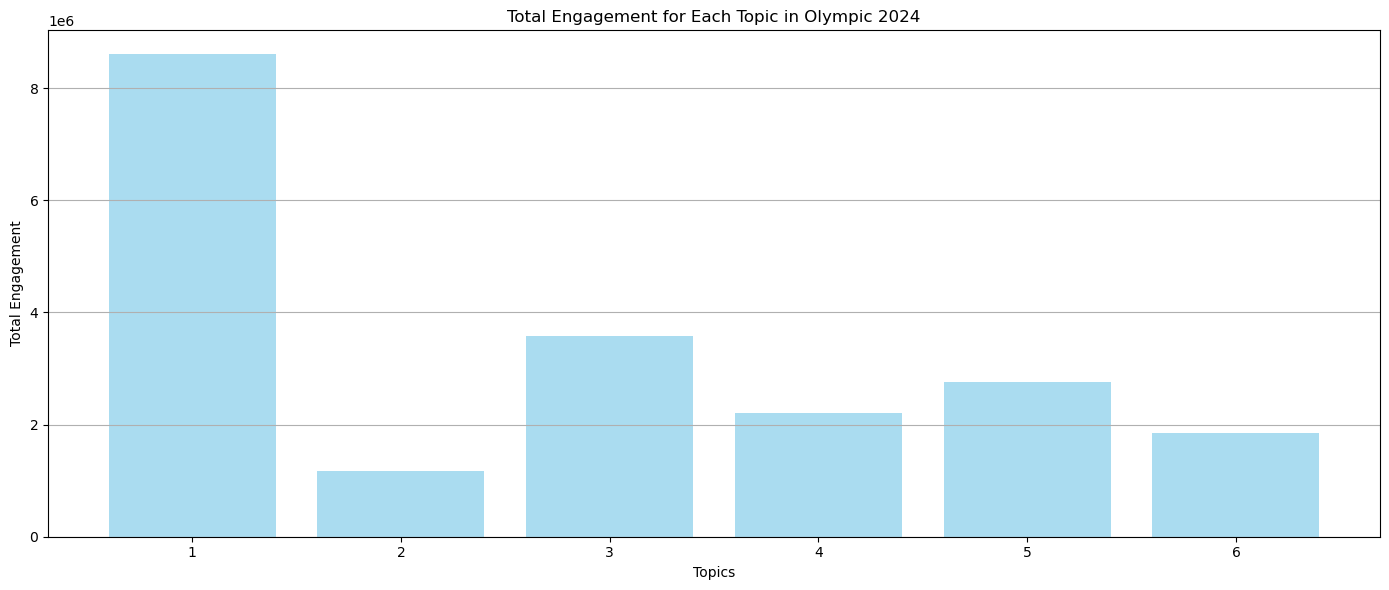

In [18]:
# topics_2024 = pd.read_csv('topics_2024.csv')
topics_2024[['title', 'text']] = topics_2024[['title', 'text']].fillna('')
topics_2024[['score', 'comments_count', 'likes', 'views', 'replies_count']] = topics_2024[['score', 'comments_count', 'likes', 'views', 'replies_count']].fillna(0)
topics_2024[['comments', 'replies']] = topics_2024[['comments', 'replies']].fillna('[]')
topics_2024['topic'] = topics_2024['topic'] + 1

# Define the topics to filter
topics = [1, 2, 3, 4, 5, 6]

# Initialize a dictionary to store results
results = {'Topic': [], 'Total Engagement': []}

# Calculate total and average engagement for each topic
for topic in topics: 
    filtered_posts = topics_2024[topics_2024['topic'] == topic]
    total_engagement = (filtered_posts['score'].sum() + filtered_posts['comments_count'].sum() + filtered_posts['likes'].sum())   

    # Append results
    results['Topic'].append(topic)
    results['Total Engagement'].append(total_engagement)

# Create a results DataFrame
results_df_2024 = pd.DataFrame(results)

# Print the results
print(results_df_2024)

# Visualize the results
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 1, figsize=(14, 6))

# Plot for Total Engagement (left subplot)
axs.bar(results_df_2024['Topic'], results_df_2024['Total Engagement'], color='skyblue', alpha=0.7)
axs.set_title('Total Engagement for Each Topic in Olympic 2024')
axs.set_xlabel('Topics')
axs.set_ylabel('Total Engagement')
axs.set_xticks(results_df_2024['Topic'])
axs.grid(axis='y')

# Adjust layout
plt.tight_layout()

# Show the plots side by side
plt.show()


### Engagement Analysis For Each Topic in Olympics 2020

In [20]:
# Initialize the list to store processed posts and comments
lPosts_2020 = []

# Iterate through 'reddit' and 'youtube' to process both data sources
for s in ['reddit', 'youtube']:
    if s == 'reddit': 
        # Iterate through each row in reddit_2020 DataFrame using itertuples()
        for row in reddit_2020.itertuples(index=True, name='RedditRow'):
            submissionsTitle = row.title
            submissionSelftext = row.text
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionSelftext, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2020.append(' '.join(lTokens))
        
        for comment_row in reddit_com_2020.itertuples(index=True, name='RedditCommentRow'):
            commentText = comment_row.text
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2020.append(' '.join(lTokens))
            
    else:  
        for row in youtube_2020.itertuples(index=True, name='YouTubeRow'):
            submissionsTitle = row.title
            submissionDescription = row.text
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionDescription, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2020.append(' '.join(lTokens))
    
        for comment_row in youtube_com_2020.itertuples(index=True, name='YouTubeCommentRow'):
            commentText = comment_row.text
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2020.append(' '.join(lTokens))

                

In [21]:
# LDA parameters

# number of topics to discover (default = 10)
topicNum = 6
# maximum number of words to display per topic (default = 10)
wordNumToDisplay = 12
# the number of features/words to used to describe our documents
featureNum = 1500

In [22]:
# Count Vectorizer

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words=['english'])
tf_2020 = tfVectorizer.fit_transform(lPosts_2020)

# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

# LDA MODEL

# Run LDA
# Random state is set so that every time it generate the same result
ldaModel_2020 = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online', random_state = 10).fit(tf_2020)
topic_prob_2020 = ldaModel_2020.transform(tf_2020)

In [23]:
topics_2020 = pd.concat([reddit_2020, reddit_com_2020, youtube_2020, youtube_com_2020], ignore_index=True)
# Find the topic with the highest topic probability for each post and comment in the dataframe
topics_2020['topic'] = topic_prob_2020.argmax(axis=1)

   Topic  Total Engagement
0      1         5291319.0
1      2         1627320.0
2      3         2440992.0
3      4         3495820.0
4      5         2172188.0
5      6         4610084.0


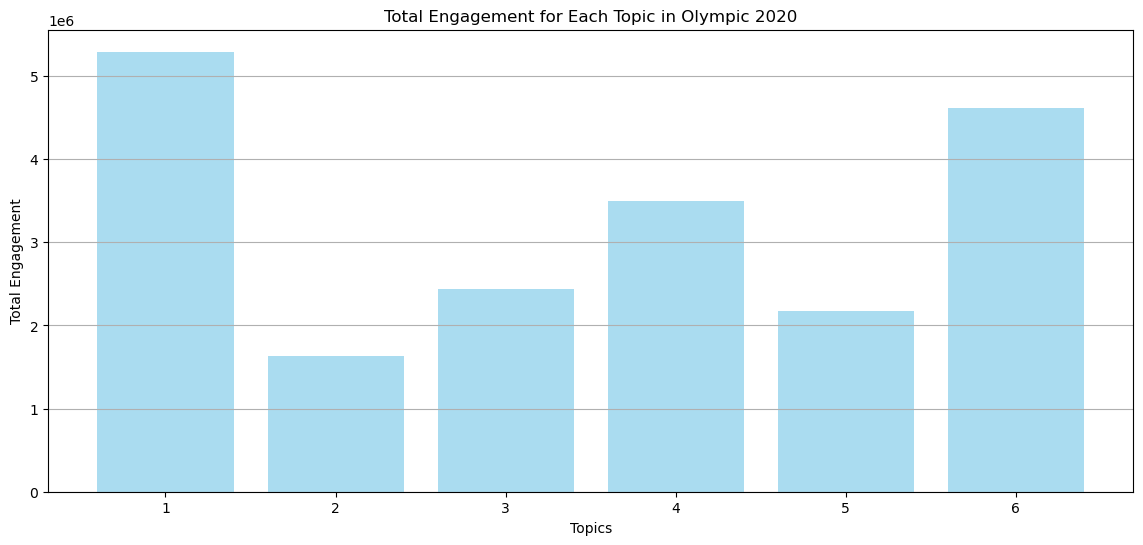

In [24]:
# topics_2020 = pd.read_csv('topics_2020.csv')
topics_2020[['title', 'text']] = topics_2020[['title', 'text']].fillna('')
topics_2020[['score', 'comments_count', 'likes', 'views', 'replies_count']] = topics_2020[['score', 'comments_count', 'likes', 'views', 'replies_count']].fillna(0)
topics_2020[['comments', 'replies']] = topics_2020[['comments', 'replies']].fillna('[]')
topics_2020['topic'] = topics_2020['topic'] + 1

# Define the topics to filter
topics = [1, 2, 3, 4, 5, 6]

# Initialize a dictionary to store results
results = {'Topic': [], 'Total Engagement': []}

# Calculate total and average engagement for each topic
for topic in topics: 
    filtered_posts = topics_2020[topics_2020['topic'] == topic]
    total_engagement = (filtered_posts['score'].sum() + filtered_posts['comments_count'].sum() + filtered_posts['likes'].sum())   

    # Append results
    results['Topic'].append(topic)
    results['Total Engagement'].append(total_engagement)

# Create a results DataFrame
results_df_2020 = pd.DataFrame(results)

# Print the results
print(results_df_2020)

# Visualize the results
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 1, figsize=(14, 6))

# Plot for Total Engagement (left subplot)
axs.bar(results_df_2020['Topic'], results_df_2020['Total Engagement'], color='skyblue', alpha=0.7)
axs.set_title('Total Engagement for Each Topic in Olympic 2020')
axs.set_xlabel('Topics')
axs.set_ylabel('Total Engagement')
axs.set_xticks(results_df_2024['Topic'])
axs.grid(axis='y')



### Engagement Analysis For Each Topic in Olympics 2016

In [26]:
# Initialize the list to store processed posts and comments
lPosts_2016 = []

# Iterate through 'reddit' and 'youtube' to process both data sources
for s in ['reddit', 'youtube']:
    if s == 'reddit': 
        # Iterate through each row in reddit_2016 DataFrame using itertuples()
        for row in reddit_2016.itertuples(index=True, name='RedditRow'):
            submissionsTitle = row.title
            submissionSelftext = row.text
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionSelftext, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2016.append(' '.join(lTokens))
        
        for comment_row in reddit_com_2016.itertuples(index=True, name='RedditCommentRow'):
            commentText = comment_row.text
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2016.append(' '.join(lTokens))
            
    else:  
        for row in youtube_2016.itertuples(index=True, name='YouTubeRow'):
            submissionsTitle = row.title
            submissionDescription = row.text
            
            # Tokenize, filter stopwords, and convert to lower case
            lTokens = processText_lem(text=submissionsTitle + ' ' + submissionDescription, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2016.append(' '.join(lTokens))
    
        for comment_row in youtube_com_2016.itertuples(index=True, name='YouTubeCommentRow'):
            commentText = comment_row.text
                
            lTokens = processText_lem(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            lPosts_2016.append(' '.join(lTokens))


In [27]:
# LDA parameters

# number of topics to discover (default = 10)
topicNum = 6
# maximum number of words to display per topic (default = 10)
wordNumToDisplay = 12
# the number of features/words to used to describe our documents
featureNum = 1500

In [28]:
# Count Vectorizer

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words=['english'])
tf_2016 = tfVectorizer.fit_transform(lPosts_2016)

# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

# LDA MODEL

# Run LDA
# Random state is set so that every time it generate the same result
ldaModel_2016 = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online', random_state = 10).fit(tf_2016)
topic_prob_2016 = ldaModel_2016.transform(tf_2016)

In [29]:
topics_2016 = pd.concat([reddit_2016, reddit_com_2016, youtube_2016, youtube_com_2016], ignore_index=True)
# Find the topic with the highest topic probability for each post and comment in the dataframe
topics_2016['topic'] = topic_prob_2016.argmax(axis=1)

   Topic  Total Engagement
0      1         1897623.0
1      2         1482546.0
2      3          720407.0
3      4         2110286.0
4      5         1353577.0
5      6          393789.0


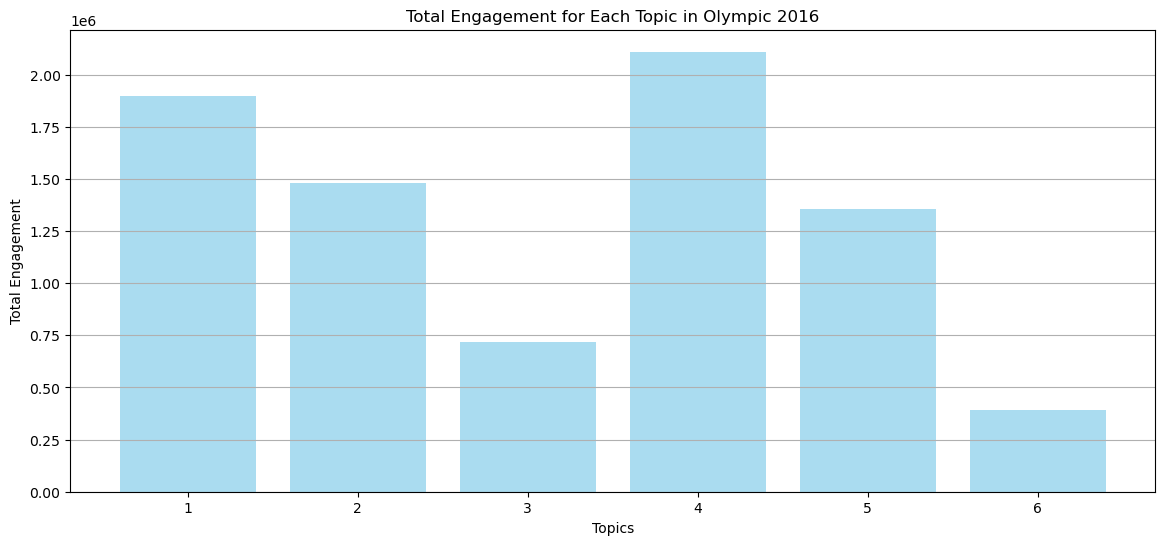

In [30]:
# topics_2016 = pd.read_csv('topics_2016.csv')
topics_2016[['title', 'text']] = topics_2016[['title', 'text']].fillna('')
topics_2016[['score', 'comments_count', 'likes', 'views', 'replies_count']] = topics_2016[['score', 'comments_count', 'likes', 'views', 'replies_count']].fillna(0)
topics_2016[['comments', 'replies']] = topics_2016[['comments', 'replies']].fillna('[]')
topics_2016['topic'] = topics_2016['topic'] + 1

# Define the topics to filter
topics = [1, 2, 3, 4, 5, 6]

# Initialize a dictionary to store results
results = {'Topic': [], 'Total Engagement': []}

# Calculate total and average engagement for each topic
for topic in topics: 
    filtered_posts = topics_2016[topics_2016['topic'] == topic]
    total_engagement = (filtered_posts['score'].sum() + filtered_posts['comments_count'].sum() + filtered_posts['likes'].sum())   

    # Append results
    results['Topic'].append(topic)
    results['Total Engagement'].append(total_engagement)

# Create a results DataFrame
results_df_2016 = pd.DataFrame(results)

# Print the results
print(results_df_2016)

# Visualize the results
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 1, figsize=(14, 6))

# Plot for Total Engagement (left subplot)
axs.bar(results_df_2016['Topic'], results_df_2016['Total Engagement'], color='skyblue', alpha=0.7)
axs.set_title('Total Engagement for Each Topic in Olympic 2016')
axs.set_xlabel('Topics')
axs.set_ylabel('Total Engagement')
axs.set_xticks(results_df_2016['Topic'])
axs.grid(axis='y')


### Most Influential People for Each Platform

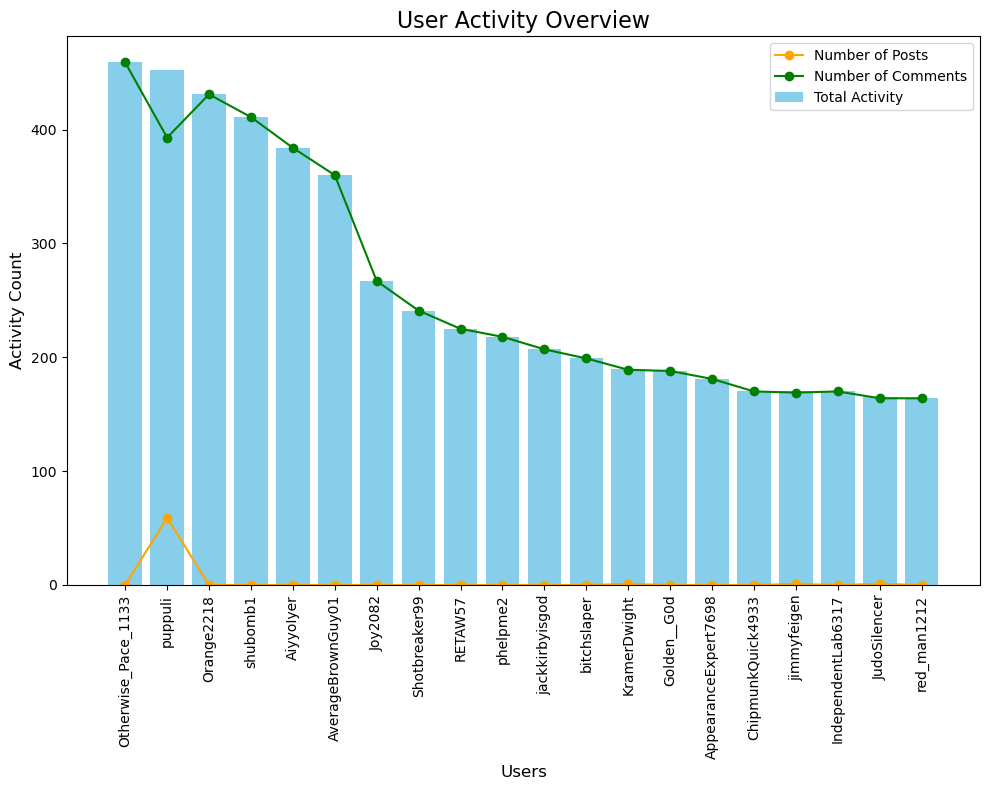

In [36]:
combined_com_reddit = pd.concat([reddit_com_2024, reddit_com_2020, reddit_com_2016], ignore_index=True)
combined_post_reddit = pd.concat([reddit_2024, reddit_2020, reddit_2016], ignore_index=True)

# Number of posts per user
reddit_posts_per_user = combined_post_reddit['title'].groupby(combined_post_reddit['author']).size().rename('num_posts')

# Number of comments per user
reddit_comments_per_user = combined_com_reddit['text'].groupby(combined_com_reddit['author']).size().rename('num_comments')

# Combine the metrics
reddit_user_activity = pd.concat([reddit_posts_per_user, reddit_comments_per_user], axis=1).fillna(0)
reddit_user_activity['total_activity'] = reddit_user_activity['num_posts'] + reddit_user_activity['num_comments']
# Remove the user "automoderator" from the user_activity DataFrame  (users have less posts, so we use total activity)
reddit_user_activity = reddit_user_activity.drop('N/A')
reddit_user_activity = reddit_user_activity.drop('AutoModerator')


# Display top active users
reddit_top_active_users = reddit_user_activity.sort_values('total_activity', ascending=False).head(20)

#draw a histogram
plt.figure(figsize=(10,8))

# Bar plot for total_activity
plt.bar(reddit_top_active_users.index, reddit_top_active_users['total_activity'], color='skyblue', label='Total Activity')

# Line plots for num_posts and num_comments
plt.plot(reddit_top_active_users.index, reddit_top_active_users['num_posts'], color='orange', marker='o', label='Number of Posts')
plt.plot(reddit_top_active_users.index, reddit_top_active_users['num_comments'], color='green', marker='o', label='Number of Comments')

# Add labels and title
plt.title('User Activity Overview', fontsize=16)
plt.xlabel('Users', fontsize=12)
plt.ylabel('Activity Count', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add a legend
plt.legend()

plt.tight_layout()
plt.show()


### Further Analysis of Otherwise_Pace_1133

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


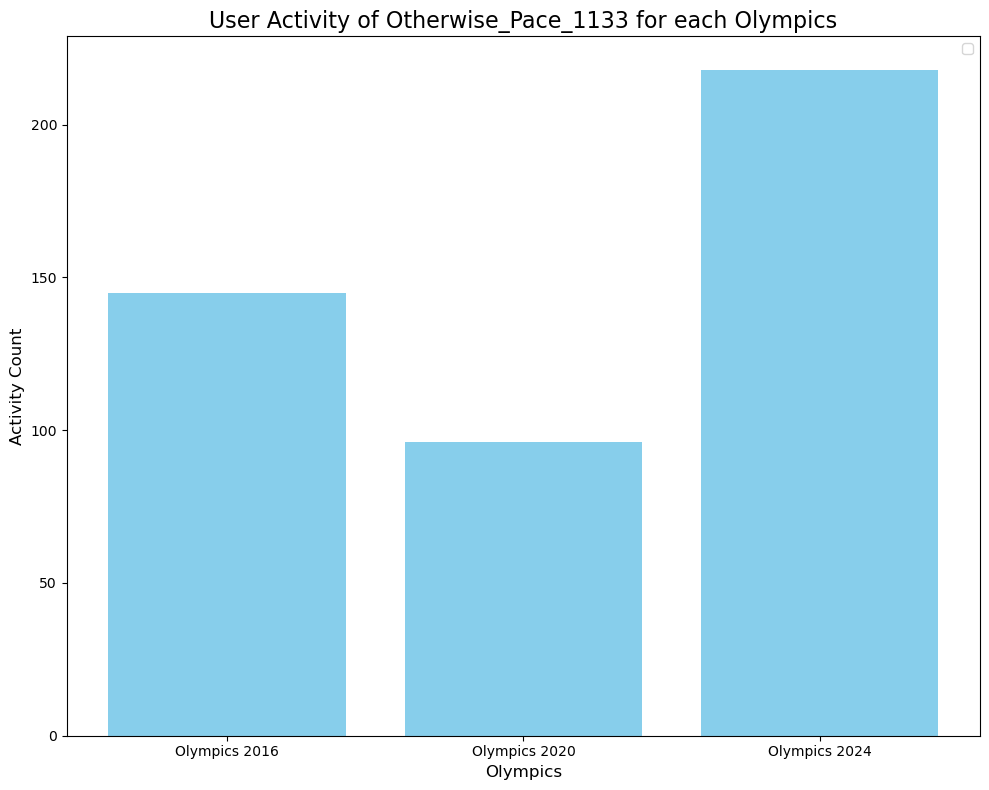

In [150]:
user_activity_2016 = len(reddit_2016.loc[(reddit_2016['author'] == 'Otherwise_Pace_1133'), ['title', 'author']]) + len(reddit_com_2016.loc[(reddit_com_2016['author'] == 'Otherwise_Pace_1133'), ['title', 'author']])
user_activity_2020 = len(reddit_2020.loc[(reddit_2020['author'] == 'Otherwise_Pace_1133'), ['title', 'author']]) + len(reddit_com_2020.loc[(reddit_com_2020['author'] == 'Otherwise_Pace_1133'), ['title', 'author']])
user_activity_2024 = len(reddit_2024.loc[(reddit_2024['author'] == 'Otherwise_Pace_1133'), ['title', 'author']]) + len(reddit_com_2024.loc[(reddit_com_2024['author'] == 'Otherwise_Pace_1133'), ['title', 'author']])

all_user_activity = {'Olympics': ['Olympics 2016', 'Olympics 2020', 'Olympics 2024'],
        'User Activity': [user_activity_2016, user_activity_2020, user_activity_2024]}

# Create DataFrame
all_user_activity_df = pd.DataFrame(all_user_activity)

#draw a histogram
plt.figure(figsize=(10,8))

# Bar plot for total_activity
plt.bar(all_user_activity_df['Olympics'], all_user_activity_df['User Activity'], color='skyblue')

# Add labels and title
plt.title('User Activity of Otherwise_Pace_1133 for each Olympics', fontsize=16)
plt.xlabel('Olympics', fontsize=12)
plt.ylabel('Activity Count', fontsize=12)

# Add a legend
plt.legend()

plt.tight_layout()
plt.show()

### Further Analysis of puppuli

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


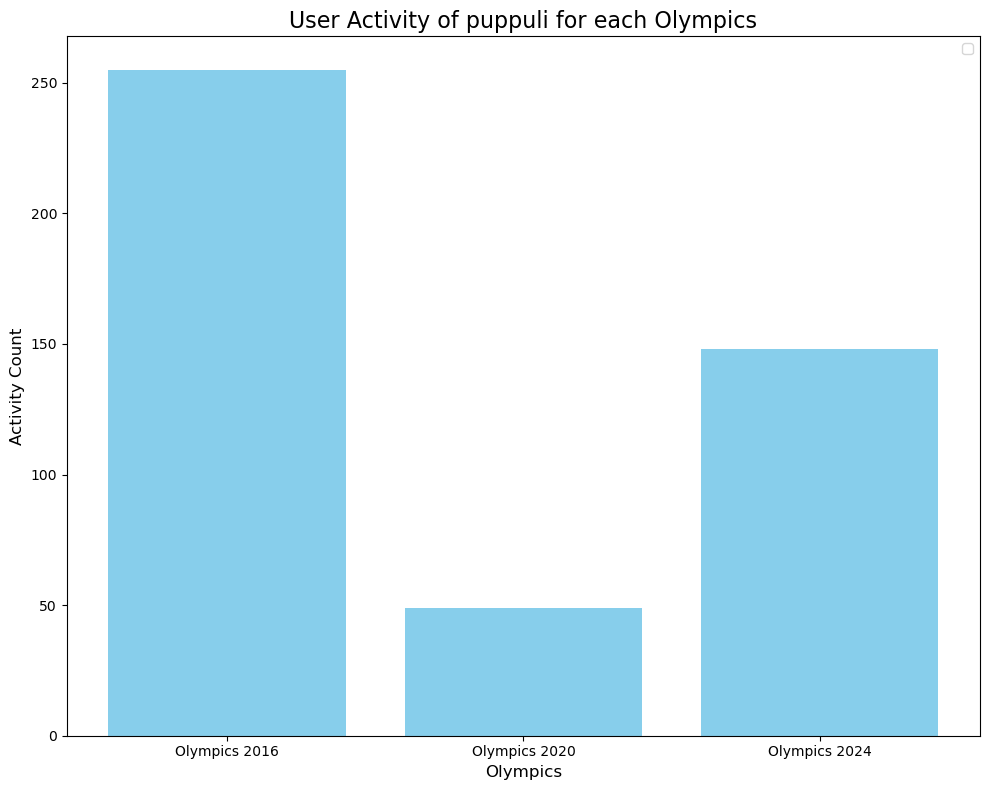

In [142]:
user_activity_2016 = len(reddit_2016.loc[(reddit_2016['author'] == 'puppuli'), ['title', 'author']]) + len(reddit_com_2016.loc[(reddit_com_2016['author'] == 'puppuli'), ['title', 'author']])
user_activity_2020 = len(reddit_2020.loc[(reddit_2020['author'] == 'puppuli'), ['title', 'author']]) + len(reddit_com_2020.loc[(reddit_com_2020['author'] == 'puppuli'), ['title', 'author']])
user_activity_2024 = len(reddit_2024.loc[(reddit_2024['author'] == 'puppuli'), ['title', 'author']]) + len(reddit_com_2024.loc[(reddit_com_2024['author'] == 'puppuli'), ['title', 'author']])

all_user_activity = {'Olympics': ['Olympics 2016', 'Olympics 2020', 'Olympics 2024'],
        'User Activity': [user_activity_2016, user_activity_2020, user_activity_2024]}

# Create DataFrame
all_user_activity_df = pd.DataFrame(all_user_activity)

#draw a histogram
plt.figure(figsize=(10,8))

# Bar plot for total_activity
plt.bar(all_user_activity_df['Olympics'], all_user_activity_df['User Activity'], color='skyblue')

# Add labels and title
plt.title('User Activity of puppuli for each Olympics', fontsize=16)
plt.xlabel('Olympics', fontsize=12)
plt.ylabel('Activity Count', fontsize=12)

# Add a legend
plt.legend()

plt.tight_layout()
plt.show()

Top Active Users:
                                 num_posts  num_comments  total_activity
Gran0129                              0.0         663.0           663.0
Olympics                            353.0         103.0           456.0
francisnguyen6349                     0.0         146.0           146.0
ChasCharlesDavisFerguson              0.0         136.0           136.0
eddie1819                             0.0         125.0           125.0
a0928347208                           0.0         115.0           115.0
jamesaaronmanarang                    0.0         113.0           113.0
isabelledavis2981                     0.0          91.0            91.0
siakum9079                            0.0          88.0            88.0
janaraujo4963                         0.0          64.0            64.0
vividarashi9859                       0.0          61.0            61.0
ninirema4532                          0.0          59.0            59.0
LarryBernat                           0.0    

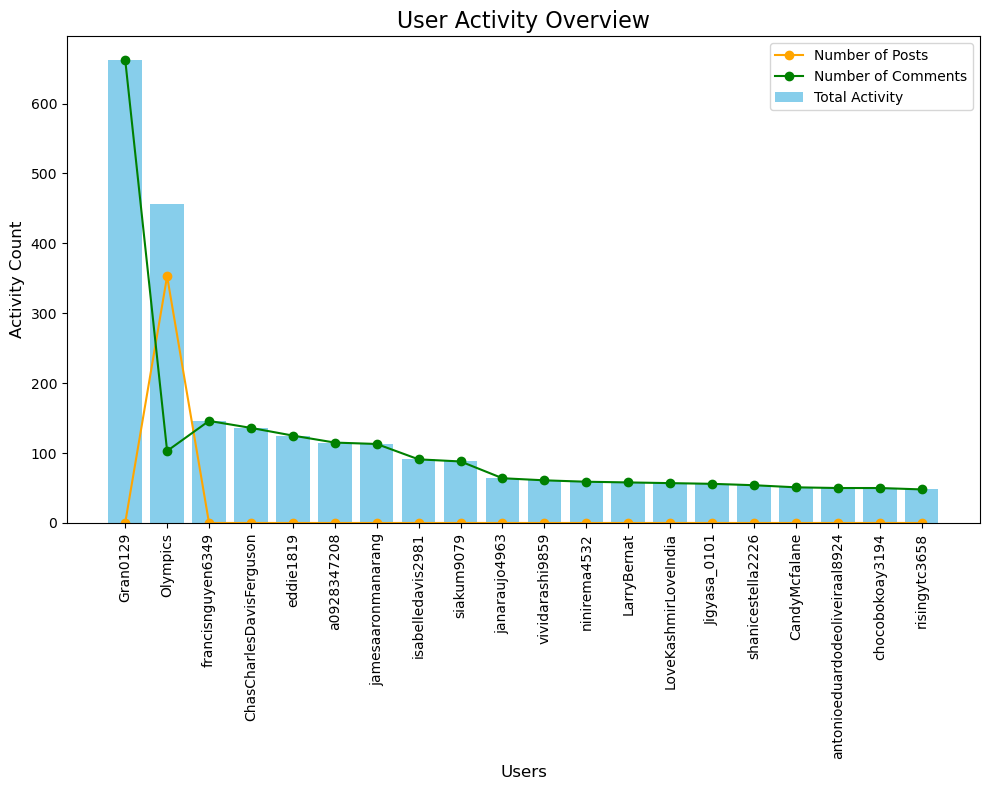

In [38]:
youtube_df = pd.read_json('youtube_olympics_data_limited_250_per_hashtag.json')
# Number of posts per user
youtube_posts_per_user = youtube_df['Video Title'].groupby(youtube_df['Video Tuthor']).size().rename('num_posts')

# Number of comments per user
youtube_df['comment author'] = youtube_df['Comments'].apply(lambda comments: [comment['author'] for comment in comments])
# youtube_df['comment author'] = youtube_df['comment author'].str.replace('@', '')
exploded_authors = youtube_df.explode('comment author')
exploded_authors['comment author'] = exploded_authors['comment author'].str.replace('@', '')
# Drop rows with null values in the 'comment authors' column in place
exploded_authors = exploded_authors.dropna(subset=['comment author'])

# Group by the exploded 'comment authors' and count the number of comments per user
youtube_comments_per_user = exploded_authors['comment author'].value_counts().rename('num_comments')

# Combine the metrics
youtube_user_activity = pd.concat([youtube_posts_per_user,youtube_comments_per_user], axis=1).fillna(0)
youtube_user_activity['total_activity'] = youtube_user_activity['num_posts'] + youtube_user_activity['num_comments']
youtube_user_activity = youtube_user_activity.drop('')

# Display top active users
youtube_top_active_users = youtube_user_activity.sort_values('total_activity', ascending=False).head(20)
print('Top Active Users:\n', youtube_top_active_users)

#draw a histogram
plt.figure(figsize=(10,8))

# Bar plot for total_activity
plt.bar(youtube_top_active_users.index, youtube_top_active_users['total_activity'], color='skyblue', label='Total Activity')

# Line plots for num_posts and num_comments
plt.plot(youtube_top_active_users.index, youtube_top_active_users['num_posts'], color='orange', marker='o', label='Number of Posts')
plt.plot(youtube_top_active_users.index, youtube_top_active_users['num_comments'], color='green', marker='o', label='Number of Comments')

# Add labels and title
plt.title('User Activity Overview', fontsize=16)
plt.xlabel('Users', fontsize=12)
plt.ylabel('Activity Count', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add a legend
plt.legend()

plt.tight_layout()
plt.show()

